In [1]:
import sys
sys.path.append("../../src")
import os
import numpy as np
import pickle
from autoencoder_LaSDI import AE_network, DI_network
from training_LaSDI import create_feed_dictionary, create_feed_dictionary2
from sindy_utils import *

import tensorflow.compat.v1 as tf
tf.compat.v1.disable_v2_behavior()
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from time import time
import seaborn as sns
import matplotlib.patches as patches
from copy import deepcopy
%matplotlib inline
import random
import subprocess as sp
from sklearn.linear_model import LinearRegression
import copy
import matplotlib.tri as tri

def get_cmap(n, name='tab20'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
cmap = get_cmap(10)

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def get_gpu_memory():
  _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]

  ACCEPTABLE_AVAILABLE_MEMORY = 1024
  COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
  memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
  memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
  return memory_free_values

device_list = tf.config.list_physical_devices('GPU')
free_mem = get_gpu_memory()
for i,gpu in enumerate(device_list):
    print(f'{gpu}: free memory: {free_mem[i]}')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): free memory: 16149
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'): free memory: 16149
PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'): free memory: 16149
PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU'): free memory: 16149


In [3]:
# specify which GPU to use
config = tf.ConfigProto(log_device_placement=False, gpu_options=tf.GPUOptions(allow_growth=True,visible_device_list='1'))

In [4]:
data_path = os.getcwd() + '/fig/nCase25b_ld3_p1_width100_lr5e-6_1e-4_scaledAE_scaledDI/'

save_name_AE = 'ex16_AE_2022_02_06_08_10_17'
save_name_DI = 'ex16_DI_2022_02_06_18_01_35'
params_AE = pickle.load(open(data_path + save_name_AE + '_params.pkl', 'rb'))
params_DI = pickle.load(open(data_path + save_name_DI + '_params.pkl', 'rb'))
params_AE['save_name'] = data_path + save_name_AE
params_DI['save_name'] = data_path + save_name_DI

In [6]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def silu(x):
    return x * sigmoid(x)

def NN(x, weights, biases, activation):
    """
    this networks serve as either an encoder or a decoder.
    """
    num_layers = len(weights)
    for i in range(num_layers-1):
        x = np.matmul(x, weights[i]) + biases[i]
        if activation == 'tanh':
            x = np.tanh(x)
        elif activation == 'sigmoid':
            x = sigmoid(x)
            
    # output layer (linear activation)
    x = np.matmul(x, weights[-1]) + biases[-1]
    return x

def derivative(x):
    dxdt = np.empty(x.shape)
    D = D_Lele(x.shape[0], tstop/x.shape[0])   
    for i in range(x.shape[1]):
        dxdt[:,i] = np.dot(D.toarray(), x[:,i])
    del D
    return dxdt

In [7]:
def eval_AE(test_data):     
    x_max, x_min = 1, 0
    if params_AE['scaled']:
        x_max = params_AE['x_max']
        x_min = params_AE['x_min']
    x = (test_data['x'] - x_min) / x_max
    z_encoder = NN(x, params_AE['AE_params'][0], params_AE['AE_params'][1], params_AE['activation']) # encoder
    u_decoder = NN(z_encoder, params_AE['AE_params'][2], params_AE['AE_params'][3], params_AE['activation']) # decoder
    u_decoder = u_decoder * x_max + x_min
    return z_encoder, u_decoder

In [8]:
def eval_LaSDI(test_data, test_param, idx=None, knn=4):  
    timer = []
#     u_decoder, u_sim, z_encoder, z_sim, dz_encoder, dz_sim, idx = 0,0,0,0,0,0,0
    
    # Step 1: set up tf graph and load parameters, can be optimized, excluded from ROM computational time
    timer.append(time()) 
    include_sine = False
    include_cosine = False
    x_max, x_min = 1, 0
    z_max, z_min = 1, 0
    if 'include_sine' in params_DI.keys():
        include_sine = params_DI['include_sine']
    if 'include_cosine' in params_DI.keys():
        include_cosine = params_DI['include_cosine']
    if params_AE['scaled']:
        x_max = params_AE['x_max']
        x_min = params_AE['x_min'] 
    if params_DI['scaled']:
        z_max = params_DI['z_max']
        z_min = params_DI['z_min']
    x = (test_data['x'] - x_min) / x_max
    z_encoder = NN(x, params_AE['AE_params'][0], params_AE['AE_params'][1], params_AE['activation']) # encoder
    u_decoder = NN(z_encoder, params_AE['AE_params'][2], params_AE['AE_params'][3], params_AE['activation']) # decoder
    u_decoder = u_decoder * x_max + x_min
    
    
    # Step 2: find the nearest neighbor (optional)
    timer.append(time()) 
    if idx == None:
        train_param = np.stack(params_DI['param'])
        idx = np.argmin(np.linalg.norm(train_param-test_param, axis=1))
    
    
    # Step 3: calculate SINDy coefficients
    timer.append(time())        
    if knn == 1:
        print(f"Index of the nearest local DI: {idx+1}")
        sindy_coeff = params_DI['DI_params'][idx]
        
    else: # KNN convex interpolation of coefficients
        dist = np.linalg.norm(train_param-test_param, axis=1)
        knn_idx = np.argsort(dist)[:knn]
        phi = np.zeros_like(knn_idx)
        if dist[knn_idx[0]] == 0: # check if the min distance is zero
            phi[0] = 1
        else:
            phi = 1 / np.linalg.norm(train_param[knn_idx]-test_param, axis=1)**2
        psi = phi / phi.sum()
        print(f"indices: {knn_idx}")
        print(f"weights: {psi}")

        sindy_coeff = np.zeros(params_DI['DI_params'][0].shape)
        for i,kidx in enumerate(knn_idx):
            sindy_coeff += psi[i] * params_DI['DI_params'][kidx]
    
    # Step 4: latent-space dynamics prediction and obtain physical dynamics
    timer.append(time())
    z_init = (z_encoder[0,:] - z_min) / z_max
    z_sim = sindy_simulate(z_init, test_data['t'].squeeze(), 
                           sindy_coeff, params_DI['poly_order'], 
                           include_sine,include_cosine)
    z_sim = z_sim * z_max + z_min
    u_sim = NN(z_sim, params_AE['AE_params'][2], params_AE['AE_params'][3], params_AE['activation'])
    u_sim = u_sim * x_max + x_min
    timer.append(time())
    
    dz_sim = derivative(z_sim)
    dz_encoder = derivative(z_encoder)
    
    timer1 = np.array(timer)
    timer2 = timer1[1:]
    timer_rom = timer2 - timer1[:-1]
    
    return u_decoder, u_sim, z_encoder, z_sim, dz_encoder, dz_sim, idx, timer_rom

### Interpolative prediction

In [9]:
knn = 1
w1 = 1.5
w2 = 2.0
tstop = 3
t_test = tstop
test_data = pickle.load(open(f"./data/local1_p1{w1:.1f}_p2{w2:.1f}_tstop{tstop:.1f}.p", "rb"))
nt = test_data['data'][0]['x'].shape[0]
t = np.linspace(0,t_test,nt)

# discretization coordinates
vert = np.loadtxt('./data/vertex.txt')
triang = tri.Triangulation(vert[:,0], vert[:,1])

test_data_x = test_data['data'][0]['x']
test_data_dx = test_data['data'][0]['dx']

In [10]:
z_encoder, u_decoder = eval_AE(test_data['data'][0])
u_decoder = u_decoder.squeeze()
print(u_decoder.shape, z_encoder.shape)

(301, 9216) (301, 3)


In [11]:
# Max relative error of all time steps
err_decoder = np.linalg.norm(test_data_x - u_decoder, axis=1) / np.linalg.norm(test_data_x, axis=1)*100
print(f'max autoencoder error: {err_decoder.max():.2f} %')

max autoencoder error: 0.80 %


In [12]:
u_decoder, u_sim, z_encoder, z_sim, dz_encoder, dz_sim, idx, timer_rom = eval_LaSDI(test_data['data'][0],
                                                                                    test_data['param'][0])
time_rom = timer_rom[1:].sum()
print(u_sim.shape, z_sim.shape)
print(f'time: {time_rom:.2f} s')

indices: [0 5 1 6]
weights: [1. 0. 0. 0.]
(301, 9216) (301, 3)
time: 0.03 s


In [13]:
# Max relative error of all time steps
err_decoder = np.linalg.norm(test_data_x - u_decoder, axis=1) / np.linalg.norm(test_data_x, axis=1)*100
err_lasdi = np.linalg.norm(test_data_x - u_sim, axis=1) / np.linalg.norm(test_data_x, axis=1)*100
print(f'max autoencoder error: {err_decoder.max():.2f} %')
print(f'max lasdi error: {err_lasdi.max():.2f} %')

max autoencoder error: 0.80 %
max lasdi error: 1.33 %


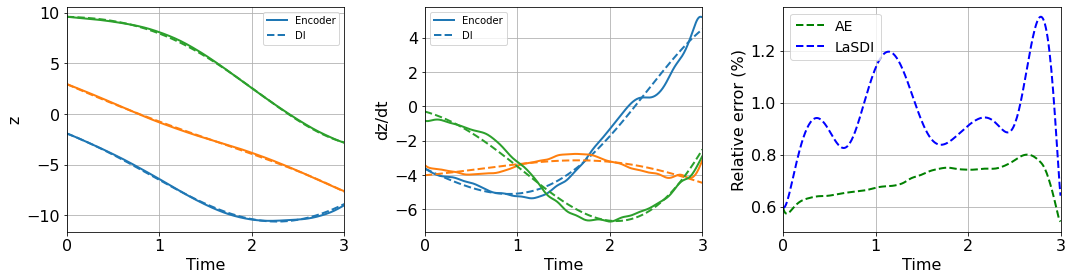

In [14]:
step = int((nt-1)/1)
# step = 0
vmin_x = 0
vmax_x = test_data_x[step,:].max()
vmin_dx = 0
vmax_dx = test_data_dx[step,:].max()/2


fig1 = plt.figure(figsize=(15,4))
ax = fig1.add_subplot(131)
for i in range(z_encoder.shape[1]):
    ax.plot(t, z_encoder[:,i], lw=2, c=cmap(i))
    ax.plot(t, z_sim[:,i], '--', lw=2, c=cmap(i))
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('z', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.legend(['Encoder', 'DI'])
ax.grid()
# ax.set_title('AE latent dynamics', fontsize=16)
ax.set_xlim(t.min(),t.max())

ax = fig1.add_subplot(132)
for i in range(z_encoder.shape[1]):
    ax.plot(t, dz_encoder[:,i], lw=2, c=cmap(i))
    ax.plot(t, dz_sim[:,i], '--', lw=2, c=cmap(i))
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('dz/dt', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.legend(['Encoder', 'DI'])
ax.grid()
# ax.set_title('AE latent dynamics', fontsize=16)
ax.set_xlim(t.min(),t.max())

ax = fig1.add_subplot(133)
ax.plot(t, err_decoder, 'g--', linewidth=2, label='AE')
ax.plot(t, err_lasdi, 'b--', linewidth=2, label='LaSDI')
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('Relative error (%)', fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.grid()
ax.legend(fontsize=14, loc='upper left')
ax.set_xlim(t.min(),t.max())

plt.tight_layout()
plt.savefig(data_path + f"/latent_dynamics.png")

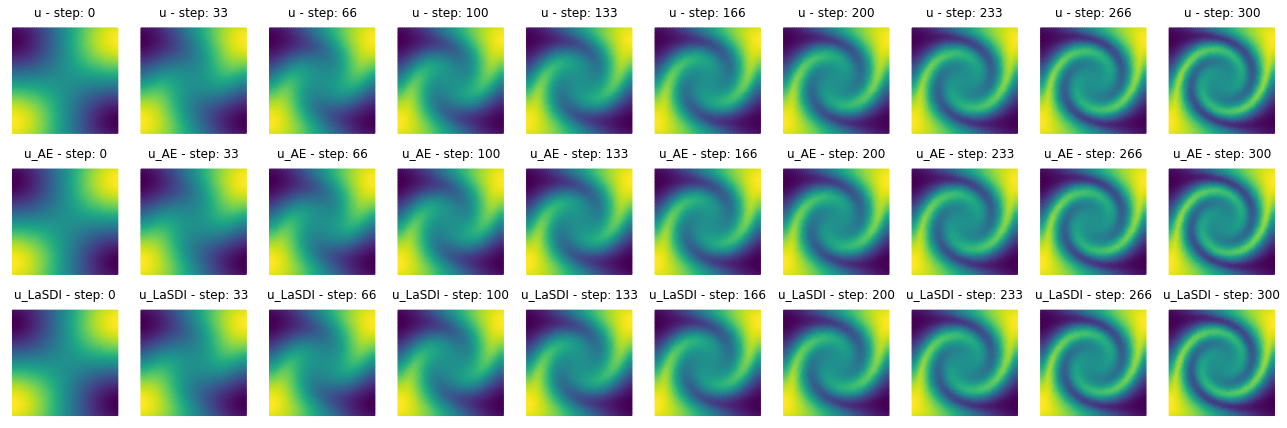

In [15]:
nstep = 10
step_list = np.linspace(0,nt-1,nstep).astype(int)
vmin_x = test_data_x.min()
vmax_x = test_data_x.max()
vmin_dx = test_data_dx.min()/5
vmax_dx = test_data_dx.max()/5

fig = plt.figure(figsize=(18,8))
for i,step in enumerate(step_list):
    ax = fig.add_subplot(4,nstep,i+1)
#     ax.tripcolor(triang, test_data_x[step], shading='gouraud')
    ax.tripcolor(triang, test_data_x[step], shading='gouraud', vmin=vmin_x, vmax=vmax_x)
    ax.set_title(f'u - step: {step}')
    ax.set_aspect('equal')
    plt.axis('off')
# plt.colorbar()
# plt.clim(test_data_x.min(), test_data_x.max())
plt.tight_layout()

for i,step in enumerate(step_list):
    ax = fig.add_subplot(4,nstep,i+1+nstep)
#     ax.tripcolor(triang, u_sim[step], shading='gouraud')
    ax.tripcolor(triang, u_decoder[step], shading='gouraud', vmin=vmin_x, vmax=vmax_x)
    ax.set_title(f'u_AE - step: {step}')
    ax.set_aspect('equal')
    plt.axis('off')
# plt.colorbar()
# plt.clim(test_data_x.min(), test_data_x.max())
plt.tight_layout()

for i,step in enumerate(step_list):
    ax = fig.add_subplot(4,nstep,i+1+2*nstep)
#     ax.tripcolor(triang, u_sim[step], shading='gouraud')
    ax.tripcolor(triang, u_sim[step], shading='gouraud', vmin=vmin_x, vmax=vmax_x)
    ax.set_title(f'u_LaSDI - step: {step}')
    ax.set_aspect('equal')
    plt.axis('off')
# plt.colorbar()
# plt.clim(test_data_x.min(), test_data_x.max())
plt.tight_layout()
    

plt.tight_layout()
plt.savefig(data_path + f"inter_pred_multisteps.png")

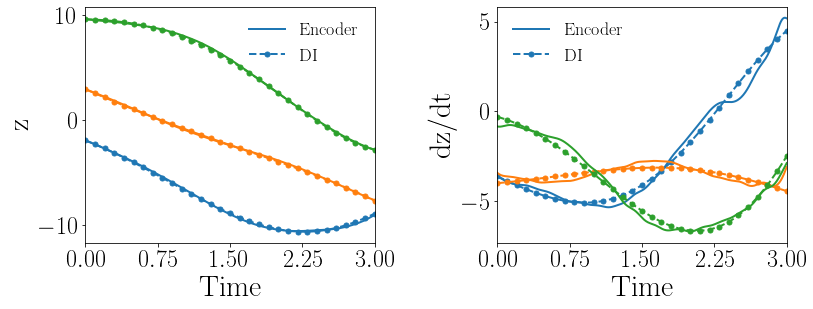

In [17]:
plt.rcParams.update({"font.size": 30,
                     "text.usetex": True,
                     "font.family": "Times New Roman"}) # fontsize for figures

fig1 = plt.figure(figsize=(12,5))
line_type = ['-','-*','-.','-^','-s']
idx = np.arange(0,t.size,10)
ax = fig1.add_subplot(121)
for i in range(z_encoder.shape[1]):
    ax.plot(t, z_encoder[:,i], '-', lw=2, c=cmap(i))
    ax.plot(t[idx], z_sim[idx,i], '--o', lw=2, markersize=5, c=cmap(i))
ax.set_xlabel('Time')
ax.set_ylabel('z')
ax.set_xticks(np.linspace(0,t.max(),5))
ax.set_ylim(z_sim.min()*1.1,z_sim.max()+1.2)
ax.tick_params(axis='both', labelsize=24)
ax.legend(['Encoder', 'DI'], loc='upper right', frameon=False, fontsize=18)
# ax.grid()
ax.set_xlim(t.min(),t.max())

ax = fig1.add_subplot(122)
for i in range(z_sim.shape[1]):
    ax.plot(t, dz_encoder[:,i], '-', linewidth=2, c=cmap(i))
    ax.plot(t[idx], dz_sim[idx,i], '--o', linewidth=2, markersize=5, c=cmap(i))
ax.set_xlabel('Time')
ax.set_ylabel('dz/dt')
ax.set_xticks(np.linspace(0,t.max(),5))
ax.set_xlim(0,t.max())
ax.set_ylim(dz_sim.min()*1.1,dz_sim.max()*1.3)
ax.tick_params(axis='both', labelsize=24)
ax.legend(['Encoder', 'DI'], loc='upper left', frameon=False, fontsize=18)
# ax.grid()

plt.tight_layout()
plt.savefig(data_path + f"advection_latent_dynamics.png",bbox_inches='tight')

### Extended domain

In [32]:
knn = 4
res_nstep = nt
res_name = f'mean'
t = np.linspace(0,tstop,nt)

na = 21
nw = na
# amp_test = np.linspace(1.5, 2, na)
# width_test = np.linspace(2, 2.5, nw)

amp_test = np.linspace(1.5, 1.8, na)
width_test = np.linspace(2, 2.3, nw)

# amp_test = params_DI['param'][:,0]
# width_test = params_DI['param'][:,1]

amp_size = amp_test.size
width_size = width_test.size
num_case = amp_size * width_size
max_err_lasdi = np.zeros([amp_size, width_size])
max_err_AE = np.zeros([amp_size, width_size])
sindy_idx = np.zeros([amp_size, width_size])
# test_data_all = pickle.load(open(f"./data/local{num_case}_tstop{tstop:.1f}.p", "rb"))
test_data_all = pickle.load(open(f"./data/local{num_case}_tstop{tstop:.1f}b.p", "rb"))

speed_up = 0
count = 0
timer_rom = np.zeros(4)
start_time = time()
for i,a in enumerate(amp_test):
    for j,w in enumerate(width_test):
        print(f'{count+1}/{num_case}:')
        test_data = {}
        test_data['data'] = [deepcopy(test_data_all['data'][count])]
        test_data['param'] = [deepcopy(test_data_all['param'][count])]
        test_data_x = test_data['data'][0]['x']
            
        u_decoder,u_sim,_,_,_,_,idx,t_rom = eval_LaSDI(test_data['data'][0], test_data['param'][0], knn=knn)
        timer_rom += t_rom
        sindy_idx[i,j] = idx+1
        
        # max error of all time steps
        max_err_AE[i,j] = (np.linalg.norm(test_data_x - u_decoder, axis=1) \
                                        / np.linalg.norm(test_data_x, axis=1)*100).max()
        max_err_lasdi[i,j] = (np.linalg.norm(test_data_x - u_sim, axis=1) \
                                        / np.linalg.norm(test_data_x, axis=1)*100).max()
        count += 1
end_time = time()
time_rom = timer_rom[1:].sum()/num_case # from Step 2 to 4
time_sim = 3.8 # seconds
speed_up = time_sim / time_rom
print(f'Time taken: {end_time-start_time:.2f} s, {(end_time-start_time)/60:.2f} mins')
print(f'Average speed up: {speed_up:.2f}')
for i,t in enumerate(timer_rom):
    print(f'ROM time{i}: {t:.8f} s')

1/441:
indices: [0 5 1 6]
weights: [1. 0. 0. 0.]
2/441:
indices: [0 1 5 6]
weights: [0.88861102 0.05553819 0.03417735 0.02167344]
3/441:
indices: [0 1 5 6]
weights: [0.5882275  0.26143444 0.08113483 0.06920323]
4/441:
indices: [1 0 6 5]
weights: [0.5882275  0.26143444 0.08113483 0.06920323]
5/441:
indices: [1 0 6 2]
weights: [0.88594416 0.05537151 0.03407478 0.02460956]
6/441:
indices: [1 2 6 0]
weights: [1. 0. 0. 0.]
7/441:
indices: [1 2 6 0]
weights: [0.88594416 0.05537151 0.03407478 0.02460956]
8/441:
indices: [1 2 6 7]
weights: [0.5882275  0.26143444 0.08113483 0.06920323]
9/441:
indices: [2 1 7 6]
weights: [0.5882275  0.26143444 0.08113483 0.06920323]
10/441:
indices: [2 1 7 3]
weights: [0.88594416 0.05537151 0.03407478 0.02460956]
11/441:
indices: [2 1 3 7]
weights: [1. 0. 0. 0.]
12/441:
indices: [2 3 7 1]
weights: [0.88594416 0.05537151 0.03407478 0.02460956]
13/441:
indices: [2 3 7 8]
weights: [0.5882275  0.26143444 0.08113483 0.06920323]
14/441:
indices: [3 2 8 7]
weights: [0.

In [33]:
print(f'max relative error (AE): {max_err_AE.max()}')
print(f'max relative error (LaSDI): {max_err_lasdi.max()}')
a_grid, w_grid = np.meshgrid(amp_test, width_test)
param_list = np.hstack([a_grid.flatten().reshape(-1,1), w_grid.flatten().reshape(-1,1)])

a_grid, w_grid = np.meshgrid(np.arange(amp_test.size), np.arange(width_test.size))
idx_list = np.hstack([a_grid.flatten().reshape(-1,1), w_grid.flatten().reshape(-1,1)])

idx_param = []
for i,ip in enumerate(params_DI['param']):
    idx = np.argmin(np.linalg.norm(param_list-ip, axis=1))
    idx_param.append((idx, np.array([param_list[idx,0], param_list[idx,1]])))

max relative error (AE): 0.800575851727552
max relative error (LaSDI): 5.407164726611295


In [34]:
# # heat map of max relative errors
# tol = 5
# sns.set(font_scale=1.3)
# def max_err_heatmap(max_err, sindy_idx, idx_list=[], idx_param=[], label='Max. Relative Error (%)', dtype='int', scale=1):
#     if dtype == 'int':
#         max_err = max_err.astype(int)
#         fmt1 = 'd'
#     else:
#         fmt1 = '.1f'
#     rect = []
# #     rect.append(patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
# #     rect.append(patches.Rectangle((amp_test.size-1, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
# #     rect.append(patches.Rectangle((amp_test.size-1, width_test.size-1), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
# #     rect.append(patches.Rectangle((0, width_test.size-1), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     for i in range(len(idx_param)):
#         print(f"idx: {idx_param[i][0]}, param: {idx_param[i][1]}")
#         idd = idx_param[i][0]
# #         rect.append(patches.Rectangle((idx_list[idd,0], idx_list[idd,1]), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#         rect.append(patches.Rectangle((idx_list[idd,1], idx_list[idd,0]), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     rect2 = deepcopy(rect)
    
#     if max_err.size < 100:
#         fig = plt.figure(figsize=(10,5))
#     else:
#         fig = plt.figure(figsize=(18,9))
    
#     # local SINDy indices
#     ax = fig.add_subplot(121)
#     sindy_idx = sindy_idx.astype(int)
#     sns.heatmap(sindy_idx, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
#                 annot=True, fmt='d', annot_kws={'size':14}, 
#                 cbar=False, cmap='Spectral', robust=True, vmin=1, vmax=len(idx_param)+5)
#     for i in rect:
#         ax.add_patch(i)
        
#     # format text labels
#     fmt = '{:0.2f}'
#     xticklabels = []
#     for item in ax.get_xticklabels():
#         item.set_text(fmt.format(float(item.get_text())))
#         xticklabels += [item]
#     yticklabels = []
#     for item in ax.get_yticklabels():
#         item.set_text(fmt.format(float(item.get_text())))
#         yticklabels += [item]
#     ax.set_xticklabels(xticklabels)
#     ax.set_yticklabels(yticklabels)
#     ax.set_xlabel('w2', fontsize=16)
#     ax.set_ylabel('w1', fontsize=16)
#     ax.set_title('Index of Selected Local DI', fontsize=16)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=30) 

#     # heatmap of max relative errors
#     fontsize = 14
#     if max_err.max() >= 10:
#         fontsize = 12
#         max_err = max_err.astype(int)
#         fmt1 = 'd'
#     ax = fig.add_subplot(122)
#     cbar_ax = fig.add_axes([0.99, 0.19, 0.018, 0.7])
#     if label == 'Residual Norm':
#         sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
#                     annot=True, annot_kws={'size':fontsize}, fmt=fmt1, 
#                     cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=params['tol']*scale)
#     else:
# #         sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
# #                     annot=True, annot_kws={'size':14}, fmt=fmt1, 
# #                     cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=params['tol2']*scale)
#         sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
#                     annot=True, annot_kws={'size':fontsize}, fmt=fmt1, 
#                     cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=max_err.max()*scale)
        
#     for i in rect2:
#         ax.add_patch(i)
        
#     # format text labels
#     fmt = '{:0.2f}'
#     xticklabels = []
#     for item in ax.get_xticklabels():
#         item.set_text(fmt.format(float(item.get_text())))
#         xticklabels += [item]
#     yticklabels = []
#     for item in ax.get_yticklabels():
#         item.set_text(fmt.format(float(item.get_text())))
#         yticklabels += [item]
#     ax.set_xticklabels(xticklabels)
#     ax.set_yticklabels(yticklabels)
#     ax.set_xlabel('w2', fontsize=16)
#     ax.set_ylabel('w1', fontsize=16)
# #     ax.set_title(f'{label} (x{scale})', fontsize=16)
#     ax.set_title(f'{label}', fontsize=16)
#     ax.set_xticklabels(ax.get_xticklabels(), rotation=30) 
    
#     plt.tight_layout()
#     if label == 'Residual Norm':
#         plt.savefig(data_path + f'heatmap_{na}x{nw}_knn{knn}_resNorm.png', bbox_inches='tight')
#     elif label == 'autoencoder':
#         plt.savefig(data_path + f'heatmap_{na}x{nw}_knn{knn}_maxRelErr_AE.png', bbox_inches='tight')
#     else:
#         plt.savefig(data_path + f'heatmap_{na}x{nw}_knn{knn}_maxRelErr_lasdi.png', bbox_inches='tight')

#     plt.show()

In [35]:
# heat map of max relative errors
plt.rcParams.update({"text.usetex": True,
                     "font.family": "Times New Roman"}) # fontsize for figures

tol = 5
sns.set(font_scale=1.3)
def max_err_heatmap(max_err, sindy_idx, idx_list=[], idx_param=[], label='Max. Relative Error (%)', dtype='int', scale=1):
    if dtype == 'int':
        max_err = max_err.astype(int)
        fmt1 = 'd'
    else:
        fmt1 = '.1f'
    rect = []
#     rect.append(patches.Rectangle((0, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     rect.append(patches.Rectangle((amp_test.size-1, 0), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     rect.append(patches.Rectangle((amp_test.size-1, width_test.size-1), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
#     rect.append(patches.Rectangle((0, width_test.size-1), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
    for i in range(len(idx_param)):
        print(f"idx: {idx_param[i][0]}, param: {idx_param[i][1]}")
        idd = idx_param[i][0]
#         rect.append(patches.Rectangle((idx_list[idd,0], idx_list[idd,1]), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
        rect.append(patches.Rectangle((idx_list[idd,1], idx_list[idd,0]), 1, 1, linewidth=2, edgecolor='k', facecolor='none'))
    rect2 = deepcopy(rect)
    
    if max_err.size < 100:
        fig = plt.figure(figsize=(5,5))
    else:
        fig = plt.figure(figsize=(9,9))

    # heatmap of max relative errors
    fontsize = 14
    if max_err.max() >= 10:
        fontsize = 12
        max_err = max_err.astype(int)
        fmt1 = 'd'
    ax = fig.add_subplot(111)
    cbar_ax = fig.add_axes([0.99, 0.19, 0.02, 0.7])
    if label == 'Residual Norm':
        sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
                    annot=True, annot_kws={'size':fontsize}, fmt=fmt1, 
                    cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=params['tol']*scale)
    else:
#         sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
#                     annot=True, annot_kws={'size':14}, fmt=fmt1, 
#                     cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=params['tol2']*scale)
        sns.heatmap(max_err*scale, ax=ax, square=True, xticklabels=width_test, yticklabels=amp_test, 
                    annot=True, annot_kws={'size':fontsize}, fmt=fmt1, 
                    cbar_ax=cbar_ax, cbar=True, cmap='vlag', robust=True, vmin=0, vmax=max_err.max()*scale)
        
    for i in rect2:
        ax.add_patch(i)
        
    # format text labels
    fmt = '{:0.2f}'
    xticklabels = []
    for item in ax.get_xticklabels():
        item.set_text(fmt.format(float(item.get_text())))
        xticklabels += [item]
    yticklabels = []
    for item in ax.get_yticklabels():
        item.set_text(fmt.format(float(item.get_text())))
        yticklabels += [item]
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_xlabel('w2', fontsize=24)
    ax.set_ylabel('w1', fontsize=24)
#     ax.set_title(f'{label} (x{scale})', fontsize=16)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30) 
    
    plt.tight_layout()
    if label == 'Residual Norm':
        plt.savefig(data_path + f'heatmap_{amp_size}x{width_size}_knn{knn}_resNorm.png', bbox_inches='tight')
    elif label == 'autoencoder':
        plt.savefig(data_path + f'heatmap_{amp_size}x{width_size}_knn{knn}_maxRelErr_AE.png', bbox_inches='tight')
    else:
        plt.savefig(data_path + f'heatmap_{amp_size}x{width_size}_knn{knn}_maxRelErr_lasdi.png', bbox_inches='tight')

    plt.show()

idx: 0, param: [1.5 2. ]
idx: 105, param: [1.5   2.075]
idx: 210, param: [1.5  2.15]
idx: 315, param: [1.5   2.225]
idx: 420, param: [1.5 2.3]
idx: 5, param: [1.575 2.   ]
idx: 110, param: [1.575 2.075]
idx: 215, param: [1.575 2.15 ]
idx: 320, param: [1.575 2.225]
idx: 425, param: [1.575 2.3  ]
idx: 10, param: [1.65 2.  ]
idx: 115, param: [1.65  2.075]
idx: 220, param: [1.65 2.15]
idx: 325, param: [1.65  2.225]
idx: 430, param: [1.65 2.3 ]
idx: 15, param: [1.725 2.   ]
idx: 120, param: [1.725 2.075]
idx: 225, param: [1.725 2.15 ]
idx: 330, param: [1.725 2.225]
idx: 435, param: [1.725 2.3  ]
idx: 20, param: [1.8 2. ]
idx: 125, param: [1.8   2.075]
idx: 230, param: [1.8  2.15]
idx: 335, param: [1.8   2.225]
idx: 440, param: [1.8 2.3]


/g/g92/he10/.conda/envs/tfvenv/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


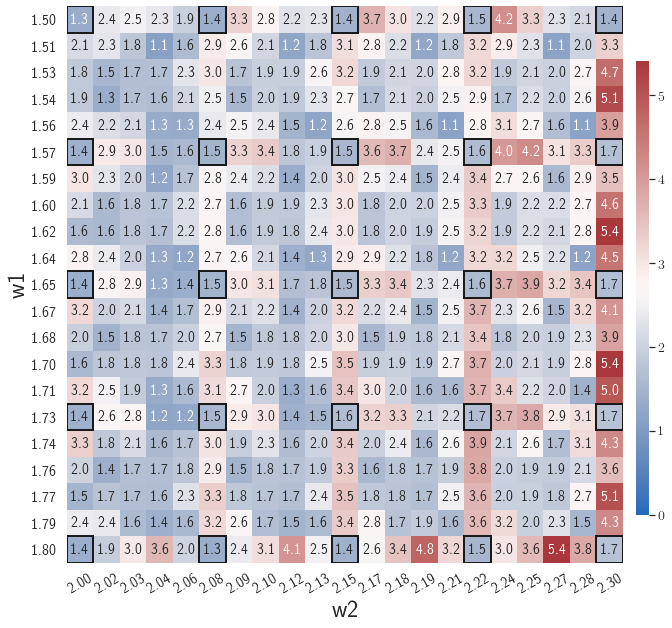

In [36]:
max_err_heatmap(max_err_lasdi, sindy_idx, idx_list, idx_param, dtype='float')

idx: 0, param: [1.5 2. ]
idx: 105, param: [1.5   2.075]
idx: 210, param: [1.5  2.15]
idx: 315, param: [1.5   2.225]
idx: 420, param: [1.5 2.3]
idx: 5, param: [1.575 2.   ]
idx: 110, param: [1.575 2.075]
idx: 215, param: [1.575 2.15 ]
idx: 320, param: [1.575 2.225]
idx: 425, param: [1.575 2.3  ]
idx: 10, param: [1.65 2.  ]
idx: 115, param: [1.65  2.075]
idx: 220, param: [1.65 2.15]
idx: 325, param: [1.65  2.225]
idx: 430, param: [1.65 2.3 ]
idx: 15, param: [1.725 2.   ]
idx: 120, param: [1.725 2.075]
idx: 225, param: [1.725 2.15 ]
idx: 330, param: [1.725 2.225]
idx: 435, param: [1.725 2.3  ]
idx: 20, param: [1.8 2. ]
idx: 125, param: [1.8   2.075]
idx: 230, param: [1.8  2.15]
idx: 335, param: [1.8   2.225]
idx: 440, param: [1.8 2.3]


/g/g92/he10/.conda/envs/tfvenv/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


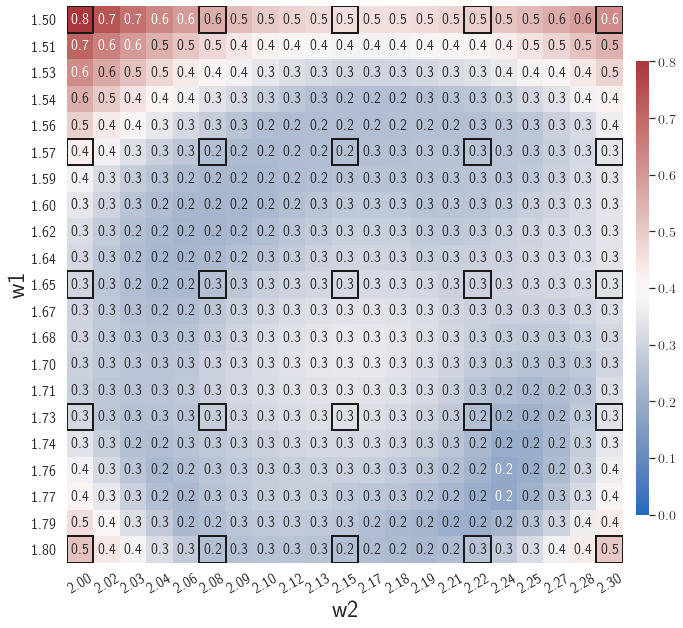

In [37]:
max_err_heatmap(max_err_AE, sindy_idx, idx_list, idx_param, dtype='float', label='autoencoder')